# Classification

### Import Packages

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold

# Set seed for RNG
SEED = 12

### Loading Dataset

In [2]:
df = pd.read_csv('reddit_combined_clean_label_split_stopword.csv') 
df['index'] = list(df.index)
df.head()

,dataset,category,subreddit,author,created_date,score,text,text_clean,label_1,label_2,label_3,final_label,text_clean_stopword,index
0,train,comment,r/cscareerquestions,Linooney,4/30/2020 1:58,20,> People wait for existing faculty to die to h...,people wait for existing faculty to die to hav...,POSITIVE,POSITIVE,NEUTRAL,POSITIVE,people wait existing faculty die space hire lm...,0
1,train,comment,r/cscareerquestions,Dunan,4/30/2020 4:07,1,"> People who are being layed off, are they sof...",people who are being layed off are they softwa...,POSITIVE,POSITIVE,NEUTRAL,POSITIVE,people layed software engineers different depa...,1
2,train,comment,r/cscareerquestions,wtfnowdoIdo,1/2/2021 0:08,0,"> Personally, I switched jobs after 1.5 years ...",personally i switched jobs after years of expe...,POSITIVE,POSITIVE,NEUTRAL,POSITIVE,personally switched jobs years experience key ...,2
3,train,comment,r/cscareerquestions,nyamuk91,4/28/2020 16:31,6,"> PM's don't do performance reviews, that's fo...",pms dont do performance reviews thats for mana...,NEUTRAL,POSITIVE,NEUTRAL,POSITIVE,pms dont performance reviews thats management ...,3
4,train,comment,r/cscareerquestions,OldSWEThrowaway,7/10/2021 2:19,-1,> pretty hard\nMore like impossible due to leg...,pretty hard more like impossible due to legal ...,POSITIVE,NEGATIVE,NEGATIVE,NEGATIVE,pretty hard like impossible due legal reasons,4


In [3]:
# Split into train, val, test
train_df = df[df['dataset'] == 'train']

X_train, X_val, y_train, y_val = train_test_split(train_df['text_clean'], 
                                                  train_df[['final_label', 'index']], 
                                                  test_size=0.2,
                                                  random_state=SEED,
                                                  shuffle=True,
                                                  stratify=train_df['final_label'])

X_test = df[df['dataset'] == 'test']['text_clean']
y_test = df[df['dataset'] == 'test'][['final_label', 'index']]

### Data Exploration

<Axes: xlabel='count', ylabel='final_label'>

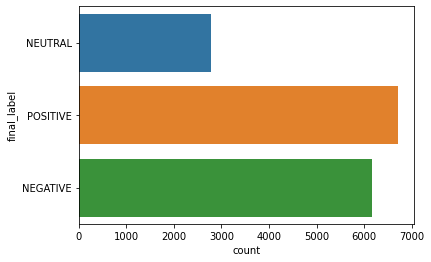

In [12]:
# Train data
sns.countplot(y="final_label", data=y_train)

<Axes: xlabel='count', ylabel='final_label'>

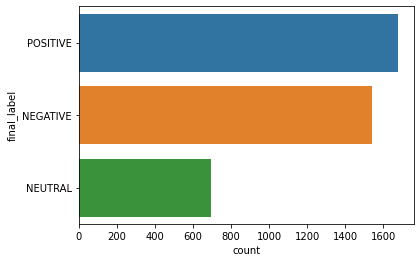

In [13]:
# Validation data
sns.countplot(y="final_label", data=y_val)

<Axes: xlabel='count', ylabel='final_label'>

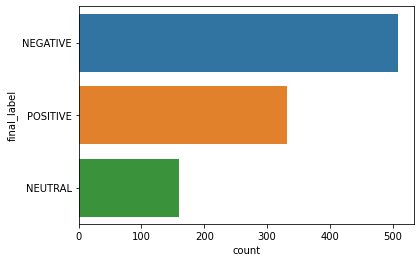

In [14]:
# Test data
sns.countplot(y="final_label", data=y_test)

### BERT

##### Model Initialization

In [5]:
tfhub_handle_encoder = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

In [6]:
# Callbacks
cb = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]

In [7]:
def build_BERT():
    
    input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='reddit')

    preprocess_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    
    encoder_inputs = preprocess_layer(input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    
    outputs = encoder(encoder_inputs)
    x = outputs['pooled_output']
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(3, activation='softmax', name='classifier')(x)
    
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    metric = tf.metrics.CategoricalAccuracy('accuracy')
    optimizer = Adam(learning_rate=5e-05, epsilon=1e-08, clipnorm=1.0)

    model = tf.keras.Model(input, x)
    model.compile(optimizer=optimizer, loss=loss, metrics=metric)
    return model

In [8]:
model = build_BERT()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 reddit (InputLayer)            [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_type_ids':   0           ['reddit[0][0]']                 
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [9]:
y_train_c = tf.keras.utils.to_categorical(y_train['final_label'].astype('category').cat.codes.values, 
                                          num_classes=3)
y_val_c = tf.keras.utils.to_categorical(y_val['final_label'].astype('category').cat.codes.values, 
                                         num_classes=3)

model.fit(x=X_train,
          y=y_train_c,
          validation_data=(X_val, y_val_c),
          epochs=5,
          callbacks=cb,
          verbose=1)

Epoch 1/5


/home/UG/luox0018/.conda/envs/patenv/lib/python3.9/site-packages/keras/backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


489/489 [==============================] - 2427s 5s/step - loss: 0.7951 - accuracy: 0.6573 - val_loss: 0.6314 - val_accuracy: 0.7454
Epoch 2/5
489/489 [==============================] - 2076s 4s/step - loss: 0.5847 - accuracy: 0.7628 - val_loss: 0.6160 - val_accuracy: 0.7658
Epoch 3/5
489/489 [==============================] - 2065s 4s/step - loss: 0.4477 - accuracy: 0.8208 - val_loss: 0.6508 - val_accuracy: 0.7628
Epoch 4/5
489/489 [==============================] - 2039s 4s/step - loss: 0.3140 - accuracy: 0.8782 - val_loss: 0.7096 - val_accuracy: 0.7623
Epoch 5/5
489/489 [==============================] - 2035s 4s/step - loss: 0.2250 - accuracy: 0.9128 - val_loss: 0.8481 - val_accuracy: 0.7671


##### Model on Test data

In [10]:
y_train_c = tf.keras.utils.to_categorical(y_train['final_label'].astype('category').cat.codes.values, 
                                          num_classes=3)
y_test_c = tf.keras.utils.to_categorical(y_test['final_label'].astype('category').cat.codes.values, 
                                         num_classes=3)

In [11]:
model.fit(x=X_train,
          y=y_train_c,
          validation_data=(X_test, y_test_c),
          epochs=5,
          callbacks=cb,
          verbose=1)

Epoch 1/5
489/489 [==============================] - 1937s 4s/step - loss: 0.1580 - accuracy: 0.9395 - val_loss: 1.1963 - val_accuracy: 0.7210
Epoch 2/5
489/489 [==============================] - 1958s 4s/step - loss: 0.1163 - accuracy: 0.9575 - val_loss: 1.2697 - val_accuracy: 0.7340
Epoch 3/5
489/489 [==============================] - 1952s 4s/step - loss: 0.0916 - accuracy: 0.9670 - val_loss: 1.3895 - val_accuracy: 0.7110
Epoch 4/5
489/489 [==============================] - 1942s 4s/step - loss: 0.0719 - accuracy: 0.9748 - val_loss: 1.5394 - val_accuracy: 0.7260
Epoch 5/5
489/489 [==============================] - 1881s 4s/step - loss: 0.0641 - accuracy: 0.9772 - val_loss: 1.4184 - val_accuracy: 0.7380


In [18]:
y_pred = model.predict(X_test)

32/32 [==============================] - 33s 1s/step


In [21]:
# Convert the predicted labels back to their original text labels
predicted_labels = np.array([np.argmax(row) for row in y_pred])
predicted_labels

array([1, 0, 1, 2, 2, 2, 2, 0, 2, 1, 1, 0, 1, 0, 0, 1, 2, 0, 0, 0, 0, 0,
       0, 2, 1, 0, 2, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1,
       2, 2, 1, 0, 2, 2, 2, 1, 0, 0, 0, 0, 0, 1, 0, 0, 2, 2, 2, 2, 0, 0,
       0, 0, 2, 0, 2, 1, 2, 1, 1, 0, 0, 1, 0, 2, 0, 0, 0, 0, 2, 2, 0, 2,
       0, 0, 1, 0, 0, 0, 1, 1, 2, 0, 0, 1, 0, 2, 0, 0, 0, 1, 2, 2, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 1, 2, 2, 2, 2,
       0, 0, 0, 1, 2, 2, 1, 0, 2, 2, 0, 2, 1, 1, 0, 0, 0, 0, 0, 2, 0, 1,
       2, 2, 0, 2, 2, 1, 2, 0, 2, 0, 1, 1, 1, 0, 0, 0, 1, 2, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 2, 2, 0, 2, 1, 0, 1, 1, 2, 1, 1, 0, 2, 0, 2,
       0, 2, 2, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 2, 2, 1, 0, 1, 2,
       0, 1, 0, 0, 1, 0, 0, 2, 1, 2, 2, 2, 0, 1, 0, 2, 1, 1, 1, 2, 0, 0,
       2, 2, 0, 0, 1, 1, 1, 0, 1, 1, 2, 2, 0, 1, 1, 0, 1, 0, 0, 2, 2, 0,
       2, 2, 0, 0, 1, 2, 0, 0, 2, 0, 0, 1, 1, 0, 2, 1, 2, 2, 0, 2, 1, 1,
       0, 0, 2, 1, 2, 1, 0, 1, 0, 0, 1, 0, 2, 0, 0,

In [25]:
temp = pd.DataFrame(predicted_labels)
temp.to_csv('findings_BERT.csv')

In [26]:
temp.head()

,0
0,1
1,0
2,1
3,2
4,2
